In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [18]:
# TODO: Define the dataset for the task. We will use the load_digits dataset from sklearn.

class DigitsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()    # float so that modules can compute with it
        self.y = torch.from_numpy(y).long() #CrossEntropyLoss expects integer class indices

    def __len__(self):      #returns the numbers of samples
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
# TODO: Define a simple neural network for the task. We will use a fully connected network with one hidden layer.
#       The input size will be 64 (8x8 images), the hidden layer will have 32 neurons, and the output layer will have 10 neurons (for digits 0-9). Use a ReLU activation function between the layers.

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32,10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [20]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()  # set to training mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion (outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_samples += batch_size
    

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()  # set to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            _, preds = torch.max(outputs,1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += batch_size

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

Epoch 1/100 | Train Loss: 1.9584 | Train Acc: 0.3563 | Val Loss: 1.2819 | Val Acc: 0.6361
Epoch 2/100 | Train Loss: 1.0088 | Train Acc: 0.7175 | Val Loss: 0.7564 | Val Acc: 0.7861
Epoch 3/100 | Train Loss: 0.6466 | Train Acc: 0.8379 | Val Loss: 0.5357 | Val Acc: 0.8306
Epoch 4/100 | Train Loss: 0.4785 | Train Acc: 0.8768 | Val Loss: 0.4087 | Val Acc: 0.9028
Epoch 5/100 | Train Loss: 0.3769 | Train Acc: 0.9081 | Val Loss: 0.3555 | Val Acc: 0.8944
Epoch 6/100 | Train Loss: 0.3133 | Train Acc: 0.9193 | Val Loss: 0.2924 | Val Acc: 0.9361
Epoch 7/100 | Train Loss: 0.2688 | Train Acc: 0.9395 | Val Loss: 0.2643 | Val Acc: 0.9444
Epoch 8/100 | Train Loss: 0.2382 | Train Acc: 0.9457 | Val Loss: 0.2470 | Val Acc: 0.9306
Epoch 9/100 | Train Loss: 0.2119 | Train Acc: 0.9534 | Val Loss: 0.2263 | Val Acc: 0.9500
Epoch 10/100 | Train Loss: 0.1933 | Train Acc: 0.9576 | Val Loss: 0.2009 | Val Acc: 0.9583
Epoch 11/100 | Train Loss: 0.1796 | Train Acc: 0.9589 | Val Loss: 0.1950 | Val Acc: 0.9611
Epoch 12

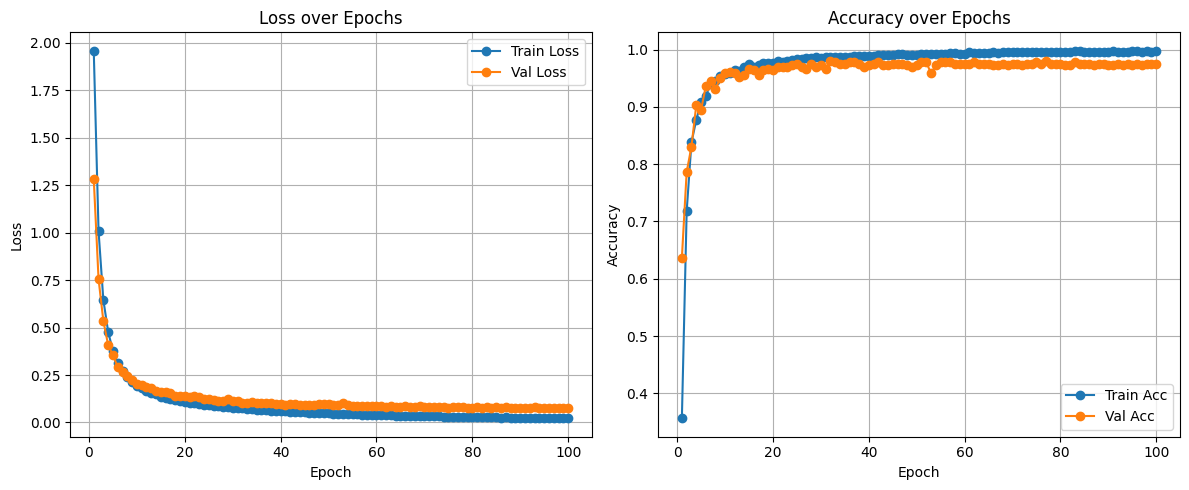

In [22]:
# --- Prepare the Dataset ---
num_classes = 10
digits = load_digits(n_class=num_classes)
X, y = digits.data, digits.target

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    random_state=1,
    stratify=y
)

# Create PyTorch datasets and dataloaders
train_dataset = DigitsDataset(X_train, y_train)
val_dataset = DigitsDataset(X_val, y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# --- Model, Loss, and Optimizer Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# --- Training Loop ---
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, marker='o', label='Train Acc')
plt.plot(epochs, val_accuracies, marker='o', label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

